## Resolution Results

This Jupyter Notebook file (resolution_results3b.ipynb) provides analysis and results form our Resolution Optimization Experiment. We use the Santa Clara Road Scene Dataset for the evaluation  of our Monocular Camera, Single LIDAR Reflection (MCSLR) Association Algorithm. We also have included the ability to evaluate the accuracy as a function of distance and number of Lidar segments in the analysis. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


## Collecting data from Resolution Analysis files

There are a total of 1000 runs of the same label video/lidar sequence from 2018-09-18 0002 data set. 

Each of the 1000 runs was an experiment of the association algoritm performed with a different Monte Carlo sample of the Hyperparameters: 

- L2_norm cost weight (w1)
- y2_distance cost weight (w2)
- Inverse IOU cost weight (w3)
- Segment Intersection cost weight (w4)
- Max Cost Threshold

The foundation for our Association method is a 4 component cost function. 

The overall cost equation is:

\begin{equation*}
c_{i,j}   = (w^1 . c^{1}_{i,j}) + (w^2 . c^{2}_{i,j}) + (w^3 . c^{3}_{i,j}) + (w^4 . c^{4}_{i,j})  
\end{equation*}

Where i is the index of the detected objects from the CNN detector and j is the index of the lidar detection.


An association is made between the CNN objects and the lidar detections using the a variant of the Hungarian Algorithm that allows for non-square matrices with an additional hyperparameter Max-cost that eliminates any association with a total cost greater that this threshold.

## Read in the summary data for all of the runs

In [2]:
!ls ../data/2018-09-18/viewer_logs/accuracy_runs/keys.csv

../data/2018-09-18/viewer_logs/accuracy_runs/keys.csv


In [3]:
data_dir = '../data/2018-09-18/viewer_logs/accuracy_runs/'
keys_filename = 'keys.csv'
keys_filepath = os.path.join(data_dir, keys_filename)

assert(os.path.exists(keys_filepath))

Each of the runs is saved in a file with a UUID based filename (hash_name) and stored in the data_dir directory listed above. The summary data for each run is saved in the same directory in a file named keys.csv

In [4]:
keys_df = pd.read_csv(keys_filepath)

In [5]:
keys_df.head()

,hash_name,count,tpcount,fpcount,fncount,accy,prec,recall,run_date,run_number,...,max_cost,enable_max_cost,use_intersecting_only,det_object_classes,run_start_frame,run_stop_frame,use_detector,min_det_confidence,enable_min_det_confidence,use_filtered_data
0,88c274fea65729ef25323fe9a5720918,1139,1124,15,0,0.9868,0.9868,1.0000,2018-09-18,2,...,0.50,True,True,['car'],650,5000,True,0.85,True,True
1,5eba0f947b2f13dfe4e95a433b9209cc,1139,1127,12,0,0.9895,0.9895,1.0000,2018-09-18,2,...,0.91,True,True,['car'],650,5000,True,0.85,True,True
2,279778716428f2efac296a365722ae7b,1139,1022,34,83,0.8973,0.9678,0.9249,2018-09-18,2,...,0.91,True,True,['car'],650,5000,True,0.85,True,True
3,6faa67261b0dbd20896f8e1deed38b23,1139,983,58,98,0.8630,0.9443,0.9093,2018-09-18,2,...,0.91,True,True,['car'],650,5000,True,0.85,True,True
4,591108db9fb352d90c6e899e347ff6fb,1139,1017,111,11,0.8929,0.9016,0.9893,2018-09-18,2,...,0.91,True,True,['car'],650,5000,True,0.85,True,True


## Exploratory Data Analysis

Let's look at the accuracy as a function of the number of segments across all of the runs

In [6]:
k = keys_df.groupby('n_segs')

n_segs
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
Name: accy, dtype: object

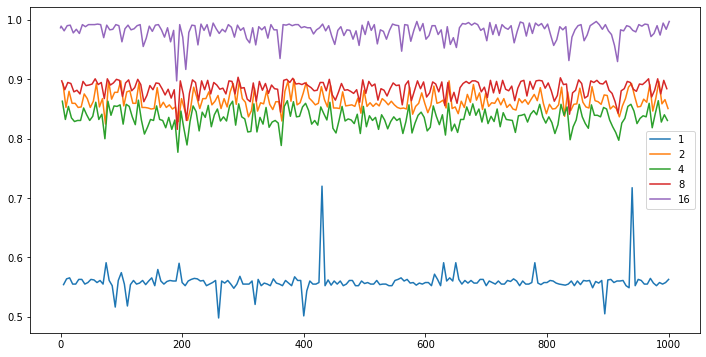

In [7]:
k.accy.plot(figsize=(12,6), legend=True)

## Analyzing accuracy as a function of distance and resolution

Each point in the curve displayed above contains the summary accuracy for every frame of video/lidar across the complete labeled dataset. The only variation is the number of segments used for the lidar detection and the hyperparameters listed above used in the association process.

To get a better understanding of the accuracy as a function of resolution, it is important to separate the object / lidar associations as a function of distance

Below we are going to analyze the data to determine if there is a distance dependancy.

Since some of the runs contain very poor association accuracy due to the particular hyperparameter settings, we will select the runs with the best performance in each resolution category for analysis.

Enter some variables

In [8]:
num_best_runs = 1    # the number of representative weights to include for each resolution
dist_tolerance = 10  # the tolerance of the distance for use in the binning procedure below

use_best_from_segment = 1 # set to zero if each resolution uses its own best weights
                          # or set to the segment number to use

segs = [16,8,4,2,1] # a list of the number of segments 

min_dist = 20        # the minimum distance for the binning process
max_dist = 120       # the maximum distance for the binning process
step_dist = 10        # the distance to step by between the min and max 

# calculate the range of distances
distances = list(range(min_dist,max_dist+1,step_dist))

# a list of columns for display purposes
cols = ['hash_name','n_segs','accy','l2_norm_weight','y2_est_weight','iou_weight','seg_intersect_weight','max_cost']


## Selecting the best runs for each number of segments

The routine below selects the 'number_of_best_runs' weights that gave the best accuracy for each number of segments 

In [9]:
max1 = keys_df.loc[keys_df.n_segs == 1].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
max2 = keys_df.loc[keys_df.n_segs == 2].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
max4 = keys_df.loc[keys_df.n_segs == 4].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
max8 = keys_df.loc[keys_df.n_segs == 8].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
max16 = keys_df.loc[keys_df.n_segs == 16].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)



The routine below overwrites the best accuracy values that were calculated with new ones with the best weights from a specific segment number if the variable 'use_best_from_segment' variable is set to 1, 2, 4, 8 or 16. If it is set to zero, the process is skipped.

These are the weights that are used for the binning process below for each resolution

In [10]:
segs_dfs = [max16, max8, max4, max2, max1]

if use_best_from_segment != 0:
    if use_best_from_segment == 16:
        maxseg = max16
    elif use_best_from_segment == 8:
        maxseg = max8
    elif use_best_from_segment == 4:
        maxseg = max4
    elif use_best_from_segment == 2:
        maxseg = max2
    else: 
        maxseg = max1
    
    for row in range(len(maxseg)):
    
        l2_norm_weight = maxseg.iloc[row,:].l2_norm_weight
        y2_est_weight = maxseg.iloc[row,:].y2_est_weight
        iou_weight = maxseg.iloc[row,:].iou_weight
        seg_intersect_weight = maxseg.iloc[row,:].seg_intersect_weight
        max_cost = maxseg.iloc[row,:].max_cost
        
        for i, seg in enumerate(segs):
            result = keys_df.loc[(keys_df.n_segs == seg) & (keys_df.l2_norm_weight == l2_norm_weight) & (keys_df.y2_est_weight == y2_est_weight) & (keys_df.iou_weight == iou_weight) & (keys_df.seg_intersect_weight == seg_intersect_weight) & (keys_df.max_cost == max_cost)]
            if row == 0:
                segs_dfs[i] = result
            else:
                segs_dfs[i] = pd.concat([segs_dfs[i], result])

In [11]:
segs_dfs[0][cols]


,hash_name,n_segs,accy,l2_norm_weight,y2_est_weight,iou_weight,seg_intersect_weight,max_cost
426,ee34a350459d2af2ad61da457b325750,16,0.9868,0.67,0.0,0.04,0.29,0.39


In [12]:
segs_dfs[1][cols]


,hash_name,n_segs,accy,l2_norm_weight,y2_est_weight,iou_weight,seg_intersect_weight,max_cost
427,eed1f94c69bee224036236b360e40df1,8,0.8946,0.67,0.0,0.04,0.29,0.39


In [13]:
segs_dfs[2][cols]


,hash_name,n_segs,accy,l2_norm_weight,y2_est_weight,iou_weight,seg_intersect_weight,max_cost
428,a2bc05df6b5e4c498ea2a78613eb411e,4,0.8534,0.67,0.0,0.04,0.29,0.39


In [14]:
segs_dfs[3][cols]


,hash_name,n_segs,accy,l2_norm_weight,y2_est_weight,iou_weight,seg_intersect_weight,max_cost
429,65388800e0a9eef16f3e79642325fb47,2,0.8876,0.67,0.0,0.04,0.29,0.39


In [15]:
segs_dfs[4][cols]


,hash_name,n_segs,accy,l2_norm_weight,y2_est_weight,iou_weight,seg_intersect_weight,max_cost
430,f484e7556a058e38eb03a36d364db739,1,0.7199,0.67,0.0,0.04,0.29,0.39


##  Binning the distance results

The procedure below sweeps the accuracy results for bins of distances spanning from from min_dist to max_dist in increments of step_dist. The purpose of this binning is to calculate the accuracy of the association process as a function of distance. The dist_tolerance variable determines how wide the bin is. By making a dist_tolerance greater than half of the step_dist, the bins will have some overlap which helps to interject some smoothing as the procedure sweeps across the distance bins.

In [16]:
print('min_dist: {}, max_dist: {}, step_dist: {}'.format(min_dist, max_dist, step_dist))
print('dist_tolerance: {}'.format(dist_tolerance))
print('number_of_best_runs: {}'.format(num_best_runs))
print('use_best_weights_from_segment: {} Note: if this is zero, each resolution uses its own best weights'.format(use_best_from_segment))

min_dist: 20, max_dist: 120, step_dist: 10
dist_tolerance: 10
number_of_best_runs: 1
use_best_weights_from_segment: 1 Note: if this is zero, each resolution uses its own best weights


In [17]:
# the binning procedure

accys_by_bin = np.zeros((len(distances), len(segs)), np.float)
sample_count = np.zeros((len(distances), len(segs)), np.float)

for j, df in enumerate(segs_dfs):
    composite_df = None
    hash_names = list(df.hash_name)
    for hash_name in hash_names:
        detail_filename = hash_name + '.csv'
        detail_filepath = os.path.join(data_dir, detail_filename)
        new_df = pd.read_csv(detail_filepath, skiprows=2)
        if composite_df is None:
            composite_df = new_df.copy()
        else:
            composite_df = pd.concat([composite_df, new_df])

    for i, dist in enumerate(distances):
        dist_df = composite_df.loc[(composite_df['gt_dist'] >= dist-dist_tolerance) & (composite_df['gt_dist'] <= dist+dist_tolerance)].copy()
        tp = dist_df.loc[dist_df.result == 'tp'].result.count()
        fp = dist_df.loc[dist_df.result == 'fp'].result.count()
        fn = dist_df.loc[dist_df.result == 'fn'].result.count()
        accys_by_bin[i,j] = tp / (tp + fp + fn)
        sample_count[i,j] = tp + fp + fn

In [18]:
# normalize compared to 16 segments accuracy
normalized_accys_by_bin = accys_by_bin.copy()
for col in range(accys_by_bin.shape[1]):
    normalized_accys_by_bin[:,col] = accys_by_bin[:,col] / accys_by_bin[:,0]

In [19]:
# normalize by highest reading for the resolution
normalized2_accys_by_bin = accys_by_bin.copy()
for col in range(accys_by_bin.shape[1]):
    normalized2_accys_by_bin[:,col] = accys_by_bin[:,col] / accys_by_bin[:,col].max()

In [20]:
labels = ['16', '8', '4', '2', '1']

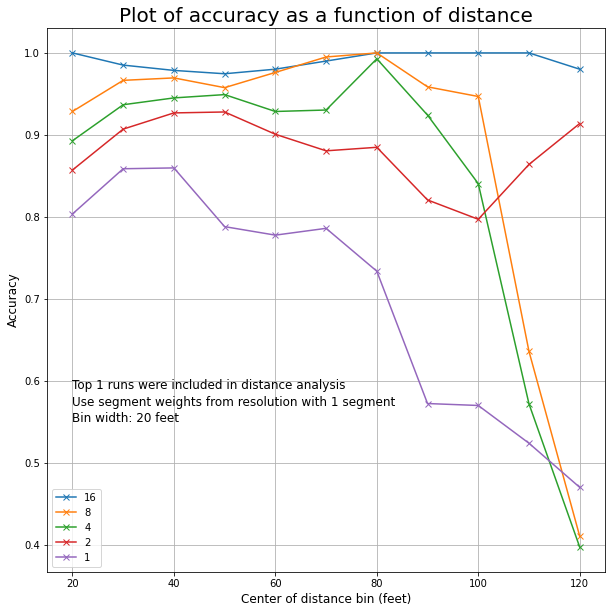

In [21]:
fig3 = plt.figure(figsize = (10,10))

ax3 = plt.axes()
plt.title('Plot of accuracy as a function of distance', fontsize=20)
plt.grid(True)
plt.xlabel('Center of distance bin (feet)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.text(20,.55, 'Bin width: {} feet'.format(2*dist_tolerance), fontsize=12)
if use_best_from_segment == 0:
    plt.text(20,.57, 'Each resolution uses its own best weights', fontsize=12)
elif use_best_from_segment == 1:
    plt.text(20,.57, 'Use segment weights from resolution with {} segment'.format(use_best_from_segment), fontsize=12)
else:
    plt.text(20,.57, 'Use segment weights from resolution with {} segments'.format(use_best_from_segment), fontsize=12)
plt.text(20,.59, 'Top {} runs were included in distance analysis'.format(num_best_runs), fontsize=12)
lines = ax3.plot(distances,accys_by_bin, marker='x')

ax3.legend(lines, labels)



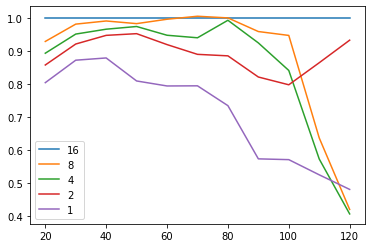

In [22]:
ax4 = plt.axes()
lines = ax4.plot(distances,normalized_accys_by_bin)
ax4.legend(lines, labels)

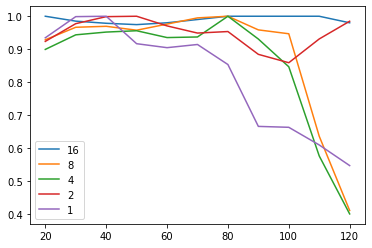

In [23]:
ax5 = plt.axes()
lines = ax5.plot(distances,normalized2_accys_by_bin)
ax5.legend(lines, labels)

## Defining a function to perform analysis

In [24]:
def analyze_distance_bins(num_best_runs, use_best_from_segment, dist_tolerance, min_dist, max_dist, step_dist, normalize=False):
    segs = [16,8,4,2,1] # a list of the number of segments 
#    segs = [16,8,4,2] # a list of the number of segments 
    labels = ['16', '8', '4', '2', '1']
#    labels = ['16', '8', '4', '2']

    text_offset_x = 15
    text_offset_y = 0.03

    # calculate the range of distances
    distances = list(range(min_dist,max_dist+1,step_dist))

    # a list of columns for display purposes
    cols = ['hash_name','n_segs','accy','l2_norm_weight','y2_est_weight','iou_weight','seg_intersect_weight','max_cost']

    max1 = keys_df.loc[keys_df.n_segs == 1].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
    max2 = keys_df.loc[keys_df.n_segs == 2].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
    max4 = keys_df.loc[keys_df.n_segs == 4].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
    max8 = keys_df.loc[keys_df.n_segs == 8].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)
    max16 = keys_df.loc[keys_df.n_segs == 16].sort_values(['accy', 'max_cost'], ascending=[False, True]).head(num_best_runs)

    segs_dfs = [max16, max8, max4, max2, max1]
#    segs_dfs = [max16, max8, max4, max2]

    if use_best_from_segment != 0:
        if use_best_from_segment == 16:
            maxseg = max16
        elif use_best_from_segment == 8:
            maxseg = max8
        elif use_best_from_segment == 4:
            maxseg = max4
        elif use_best_from_segment == 2:
            maxseg = max2
        else: 
            maxseg = max1

        for row in range(len(maxseg)):

            l2_norm_weight = maxseg.iloc[row,:].l2_norm_weight
            y2_est_weight = maxseg.iloc[row,:].y2_est_weight
            iou_weight = maxseg.iloc[row,:].iou_weight
            seg_intersect_weight = maxseg.iloc[row,:].seg_intersect_weight
            max_cost = maxseg.iloc[row,:].max_cost

            for i, seg in enumerate(segs):
                result = keys_df.loc[(keys_df.n_segs == seg) & (keys_df.l2_norm_weight == l2_norm_weight) & (keys_df.y2_est_weight == y2_est_weight) & (keys_df.iou_weight == iou_weight) & (keys_df.seg_intersect_weight == seg_intersect_weight) & (keys_df.max_cost == max_cost)]
                if row == 0:
                    segs_dfs[i] = result
                else:
                    segs_dfs[i] = pd.concat([segs_dfs[i], result])
                    
#    print('min_dist: {}, max_dist: {}, step_dist: {}'.format(min_dist, max_dist, step_dist))
#    print('dist_tolerance: {}'.format(dist_tolerance))
#    print('number_of_best_runs: {}'.format(num_best_runs))
#    print('use_best_weights_from_segment: {} Note: if this is zero, each resolution uses its own best weights'.format(use_best_from_segment))
    
    # the binning procedure

    accys_by_bin = np.zeros((len(distances), len(segs)), np.float)
    sample_count = np.zeros((len(distances), len(segs)), np.float)

    for j, df in enumerate(segs_dfs):
        composite_df = None
        hash_names = list(df.hash_name)
        for hash_name in hash_names:
            detail_filename = hash_name + '.csv'
            detail_filepath = os.path.join(data_dir, detail_filename)
            new_df = pd.read_csv(detail_filepath, skiprows=2)
            if composite_df is None:
                composite_df = new_df.copy()
            else:
                composite_df = pd.concat([composite_df, new_df])

        for i, dist in enumerate(distances):
            dist_df = composite_df.loc[(composite_df['gt_dist'] >= dist-dist_tolerance) & (composite_df['gt_dist'] <= dist+dist_tolerance)].copy()
            tp = dist_df.loc[dist_df.result == 'tp'].result.count()
            fp = dist_df.loc[dist_df.result == 'fp'].result.count()
            fn = dist_df.loc[dist_df.result == 'fn'].result.count()
            accys_by_bin[i,j] = tp / (tp + fp + fn)
            sample_count[i,j] = tp + fp + fn
    if normalize:
        # normalize compared to 16 segments accuracy
        normalized_accys_by_bin = accys_by_bin.copy()
        for col in range(accys_by_bin.shape[1]):
            normalized_accys_by_bin[:,col] = accys_by_bin[:,col] / accys_by_bin[:,0]

        # normalize by highest reading for the resolution
        normalized2_accys_by_bin = accys_by_bin.copy()
        for col in range(accys_by_bin.shape[1]):
            normalized2_accys_by_bin[:,col] = accys_by_bin[:,col] / accys_by_bin[:,col].max()    
        
    
    fig3 = plt.figure(figsize = (10,10))

    ax3 = plt.axes()
    lines = ax3.plot(distances,accys_by_bin, marker='x')
    plt.title('Plot of accuracy as a function of distance', fontsize=20)
    plt.grid(True)
    plt.xlabel('Center of distance bin (feet)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text(xmin+text_offset_x,ymin+text_offset_y+.04, 'Bin width: {} feet'.format(2*dist_tolerance), fontsize=12)
    if use_best_from_segment == 0:
        plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Each resolution uses its own best weights', fontsize=12)
    elif use_best_from_segment == 1:
        plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segment'.format(use_best_from_segment), fontsize=12)
    else:
        plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segments'.format(use_best_from_segment), fontsize=12)
    if num_best_runs == 1:
        plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The highest accuracy run was included in distance analysis'.format(num_best_runs), fontsize=12)
    else:
        plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The {} highest accuracy runs were included in distance analysis'.format(num_best_runs), fontsize=12)

    ax3.legend(lines, labels)    

    if normalize:
        fig4 = plt.figure(figsize = (10,10))

        ax4 = plt.axes()
        lines = ax4.plot(distances,normalized_accys_by_bin)
        plt.title('Plot of accuracy as a function of distance \n normalized across distance by 16 segment accuracy', fontsize=15)
        plt.grid(True)
        plt.xlabel('Center of distance bin (feet)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)

        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text(xmin+text_offset_x,ymin+text_offset_y+.04, 'Bin width: {} feet'.format(2*dist_tolerance), fontsize=12)
        if use_best_from_segment == 0:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Each resolution uses its own best weights', fontsize=12)
        elif use_best_from_segment == 1:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segment'.format(use_best_from_segment), fontsize=12)
        else:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segments'.format(use_best_from_segment), fontsize=12)
        if num_best_runs == 1:
            plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The highest accuracy run was included in distance analysis'.format(num_best_runs), fontsize=12)
        else:
            plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The {} highest accuracy runs were included in distance analysis'.format(num_best_runs), fontsize=12)

        ax4.legend(lines, labels)

        fig5 = plt.figure(figsize = (10,10))

        ax5 = plt.axes()
        lines = ax5.plot(distances,normalized2_accys_by_bin)
        plt.title('Plot of accuracy as a function of distance \n normalized across distance by best accuracy of resolution', fontsize=20)
        plt.grid(True)
        plt.xlabel('Center of distance bin (feet)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text(xmin+text_offset_x,ymin+text_offset_y+.04, 'Bin width: {} feet'.format(2*dist_tolerance), fontsize=12)
        if use_best_from_segment == 0:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Each resolution uses its own best weights', fontsize=12)
        elif use_best_from_segment == 1:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segment'.format(use_best_from_segment), fontsize=12)
        else:
            plt.text(xmin+text_offset_x,ymin+text_offset_y+.02, 'Use segment weights from resolution with {} segments'.format(use_best_from_segment), fontsize=12)
        if num_best_runs == 1:
            plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The highest accuracy run was included in distance analysis'.format(num_best_runs), fontsize=12)
        else:
            plt.text(xmin+text_offset_x,ymin+text_offset_y, 'The {} highest accuracy runs were included in distance analysis'.format(num_best_runs), fontsize=12)
        ax5.legend(lines, labels)
    
    plt.show()

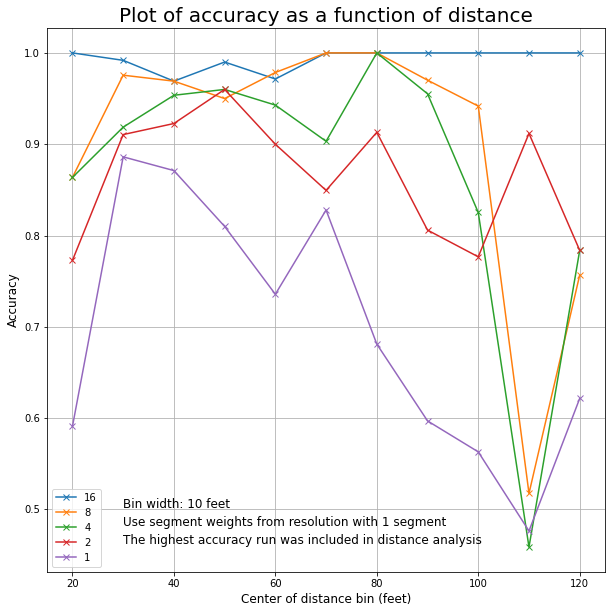

In [25]:
num_best_runs = 1          # the number of representative weights to include for each resolution
dist_tolerance = 5        # the tolerance of the distance for use in the binning procedure below

use_best_from_segment = 1  # set to zero if each resolution uses its own best weights
                           # or set to the segment number to use

min_dist = 20              # the minimum distance for the binning process
max_dist = 120             # the maximum distance for the binning process
step_dist = 10             # the distance to step by between the min and max 

analyze_distance_bins(num_best_runs, use_best_from_segment, dist_tolerance, min_dist, max_dist, step_dist)

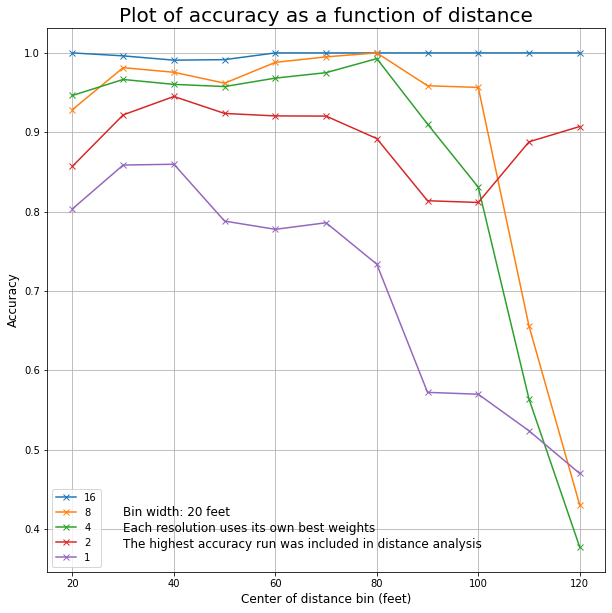

In [26]:
num_best_runs = 1          # the number of representative weights to include for each resolution
dist_tolerance = 10        # the tolerance of the distance for use in the binning procedure below

use_best_from_segment = 0  # set to zero if each resolution uses its own best weights
                           # or set to the segment number to use

min_dist = 20              # the minimum distance for the binning process
max_dist = 120             # the maximum distance for the binning process
step_dist = 10             # the distance to step by between the min and max 

analyze_distance_bins(num_best_runs, use_best_from_segment, dist_tolerance, min_dist, max_dist, step_dist)

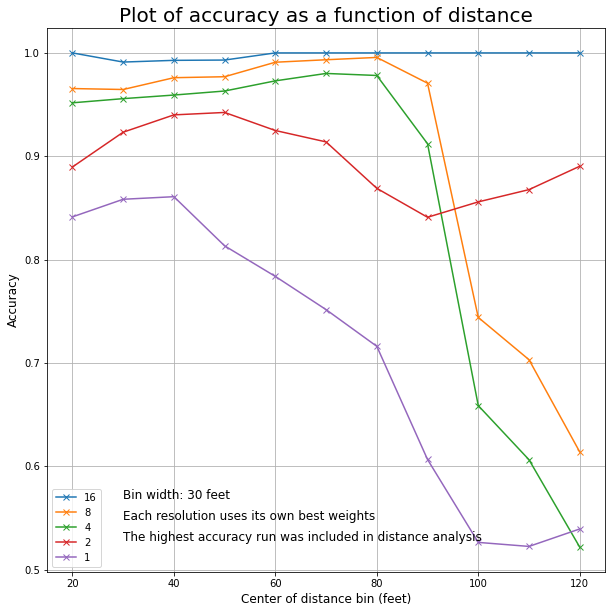

In [27]:
num_best_runs = 1          # the number of representative weights to include for each resolution
dist_tolerance = 15        # the tolerance of the distance for use in the binning procedure below

use_best_from_segment = 0  # set to zero if each resolution uses its own best weights
                           # or set to the segment number to use

min_dist = 20              # the minimum distance for the binning process
max_dist = 120             # the maximum distance for the binning process
step_dist = 10             # the distance to step by between the min and max 

analyze_distance_bins(num_best_runs, use_best_from_segment, dist_tolerance, min_dist, max_dist, step_dist)

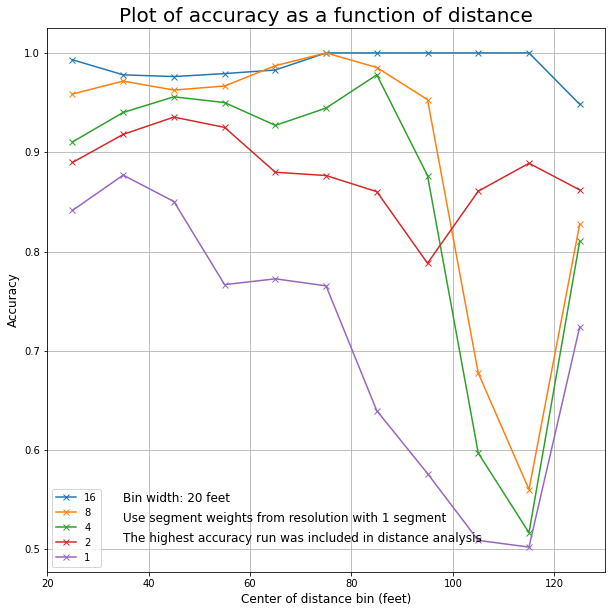

In [28]:
num_best_runs = 1          # the number of representative weights to include for each resolution
dist_tolerance = 10        # the tolerance of the distance for use in the binning procedure below

use_best_from_segment = 1  # set to zero if each resolution uses its own best weights
                           # or set to the segment number to use

min_dist = 25              # the minimum distance for the binning process
max_dist = 125             # the maximum distance for the binning process
step_dist = 10             # the distance to step by between the min and max 

analyze_distance_bins(num_best_runs, use_best_from_segment, dist_tolerance, min_dist, max_dist, step_dist)